In [76]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import datetime
from PIL import Image

In [77]:
# ! pip install -q kaggle

# Need kaggle.json
We Need a `kaggle.json` input that you can get from your kaggle account.
For mor information on how to get it refer: [Easiest way to download kaggle data in Google Colab](https://www.kaggle.com/general/74235)


In [78]:
# from google.colab import files
# files.upload()

In [79]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [80]:
# ! kaggle datasets download -d theblackmamba31/landscape-image-colorization
# ! echo "A" | unzip landscape-image-colorization.zip > /dev/null
# ! ls

In [81]:
start = time.time()

In [82]:
ROOT_DIR = 'landscape Images/'
GRAY_DIR = ROOT_DIR + 'gray/'
COLOR_DIR = ROOT_DIR + 'color/'
LIMIT = 7128

# The range of files in the Colored images directory

In [83]:
file_names = os.listdir(COLOR_DIR)
file_names.sort(key=lambda x: int(x.split('.')[0]))
file_names = file_names[:LIMIT]
print('Range: ', file_names[0], file_names[-1], len(file_names))

Range:  0.jpg 7127.jpg 7128


# Sample images:

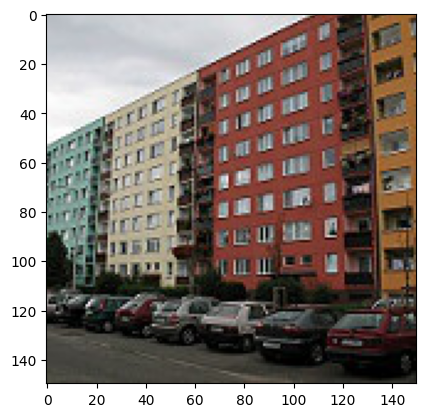

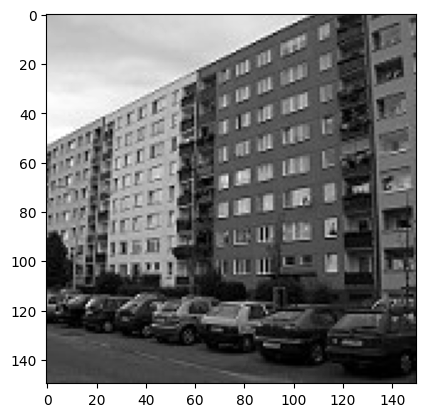

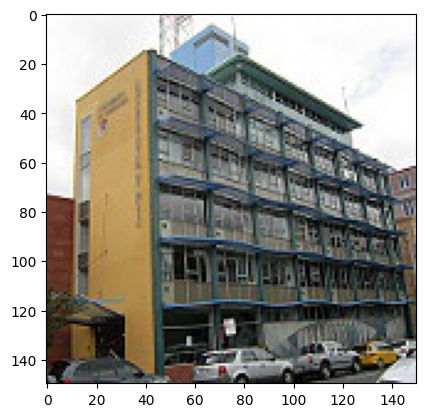

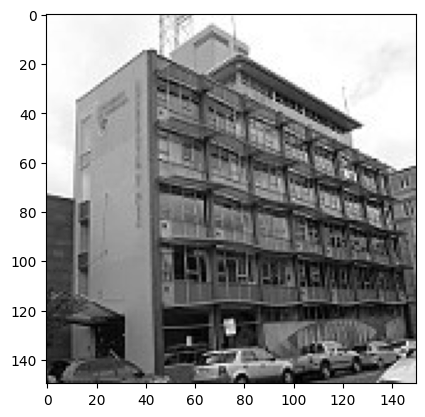

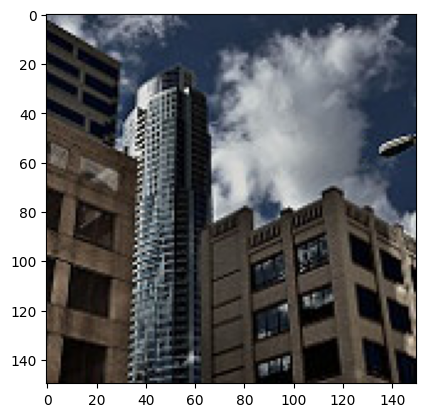

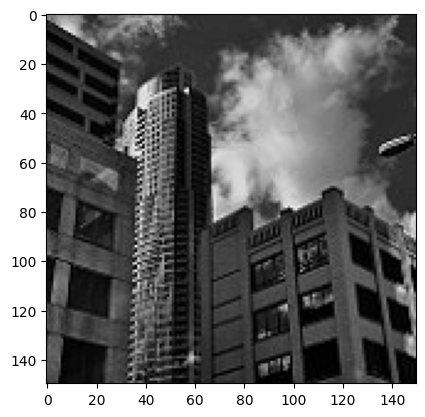

In [84]:
for fileName in file_names[-3:]:
    color_img = mpimg.imread(COLOR_DIR + fileName)
    gray_img = mpimg.imread(GRAY_DIR + fileName)
    color_imgplot = plt.imshow(color_img)
    plt.show()
    gray_imgplot = plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255)
    plt.show()

# Total number of colored images

In [85]:
tot_color_images = len(os.listdir(COLOR_DIR)[:LIMIT])
tot_color_images

7128

# Total number of gray scaled images

In [86]:
tot_gray_images = len(os.listdir(GRAY_DIR)[:LIMIT])
tot_gray_images

7128

# We will now need to resize and normalize all the input images to a preferable normal

In [87]:
height, width, channel = 256, 256, 3
input_shape = (height, width, 1)
images_name = next(os.walk(COLOR_DIR))[2]
images_name = images_name[:LIMIT]

In [88]:
# TO-DO: Resizing...
all_colored_images_normalized = np.zeros((len(images_name), height, width, channel), dtype=np.uint8)
all_gray_images_normalized = np.zeros((len(images_name), height, width), dtype=np.uint8)
for image_index, image_name in tqdm(enumerate(images_name)):
    # Adding image names with base directory to get full path for every images
    colored_image_path = COLOR_DIR + image_name + ''
    colored_image_info = imread(colored_image_path)

    gray_image_path = GRAY_DIR + image_name + ''
    gray_image_info = imread(gray_image_path)

    # Resizing every image to 256*256 as declared previously
    colored_image_info = resize(colored_image_info, (height, width), mode='constant', preserve_range=True)
    all_colored_images_normalized[image_index] = colored_image_info

    gray_image_info = resize(gray_image_info, (height, width), mode='constant', preserve_range=True)
    all_gray_images_normalized[image_index] = gray_image_info

# Normalizing values between 0 to 1 by diving
all_colored_images_normalized = all_colored_images_normalized.astype('float32') / 256.0
all_gray_images_normalized = all_gray_images_normalized.astype('float32') / 256.0

7128it [01:01, 115.58it/s]


In [89]:
train_output, test_output = train_test_split(all_colored_images_normalized, test_size=0.2, random_state=25)
train_input, test_input = train_test_split(all_gray_images_normalized, test_size=0.2, random_state=25)

In [90]:
len(train_output)

5702

In [91]:
len(train_input)

5702

In [92]:
len(test_output)

1426

In [93]:
len(test_input)

1426

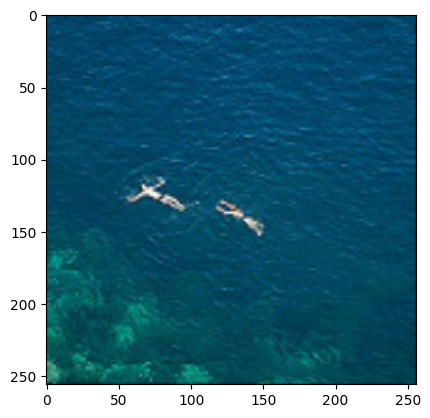

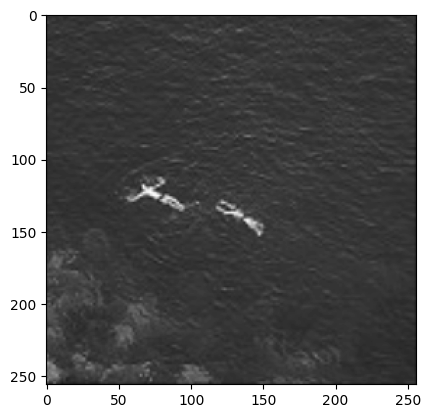

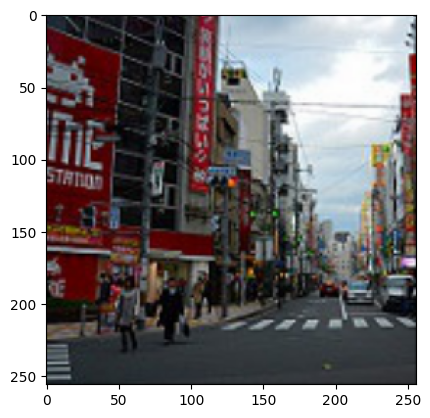

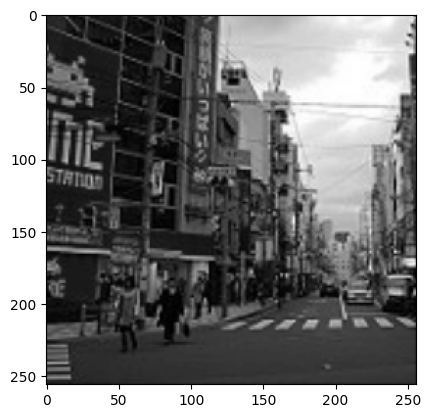

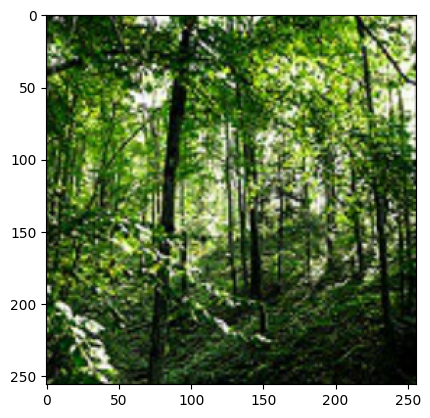

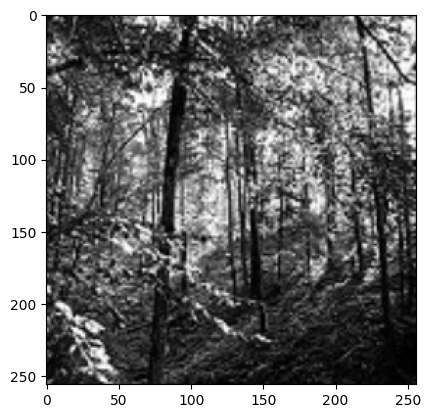

In [94]:
for index in range(3):
    color_img_plt = plt.imshow(train_output[index])
    plt.show()
    gray_img_plt = plt.imshow(train_input[index], cmap='gray', vmin=0, vmax=1)
    plt.show()

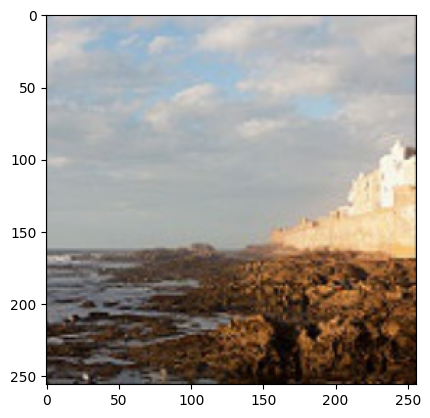

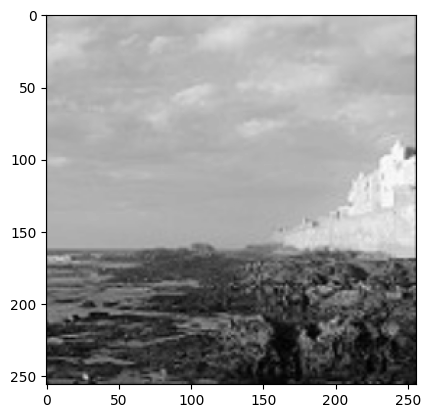

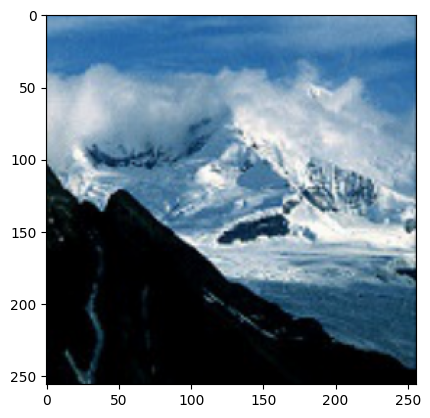

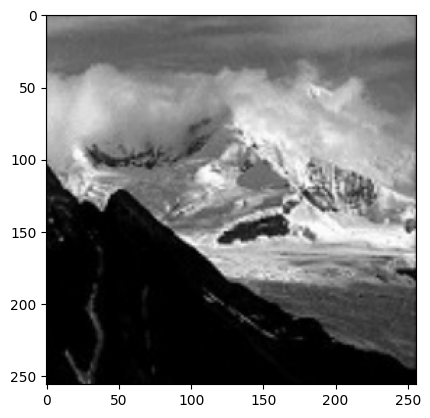

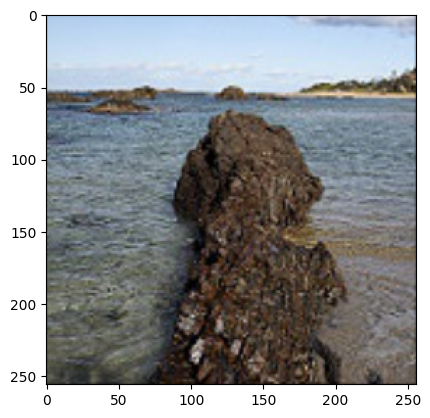

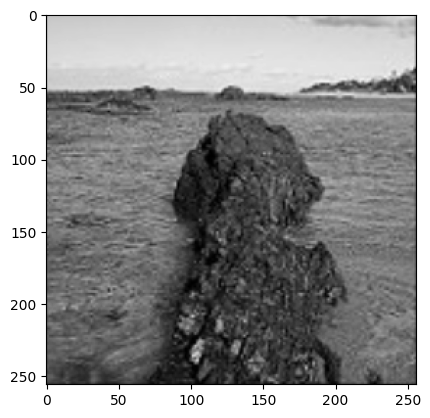

In [95]:
for index in range(3):
    color_img_plt = plt.imshow(test_output[index])
    plt.show()
    gray_img_plt = plt.imshow(test_input[index], cmap='gray', vmin=0, vmax=1)
    plt.show()

In [96]:
end = time.time()
print(f'Execution time: {str(datetime.timedelta(seconds=(end - start)))} (HH:MM:SS)')

Average Execution time: 0:03:07.975647 (HH:MM:SS)


# References
[To download data from Kaggle into a Colab Notebook Kaggle](https://www.kaggle.com/general/74235)

[Image Colorizer by SHUVRO MAC](https://www.kaggle.com/shuvromac/final-version-colorization)